In [164]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
import itertools
import pandas as pd
from scipy.signal import find_peaks

# Lecture 5: Graph colouring

### Figure 1: Entropy for paramagnetic phase

In [165]:
def paramagnetic_bfe(c, beta, q):
    '''
    args:
        c: average degree of graph
        beta: inverse temperature
        q: number of colours
    returns:
        Bethe free entropy for paramagnetic fixed point
    '''
    return np.log(q) + c/2 * np.log(1-(1-np.exp(-beta))/q)

def paramagnetic_energy(c, beta, q):
    '''
    args:
        c: average degree of graph
        beta: inverse temperature
        q: number of colours
    returns:
        energy cost for paramagnetic fixed point
    '''
    return c/2 * np.exp(-beta) / (q-1+np.exp(-beta))
    
def paramagnetic_entropy(c, beta, q):
    '''
    args:
        c: average degree of graph
        beta: inverse temperature
        q: number of colours
    returns:
        entropy for paramagnetic fixed point
    '''
    return (paramagnetic_bfe(c, beta, q) + 
            beta * paramagnetic_energy(c, beta, q))

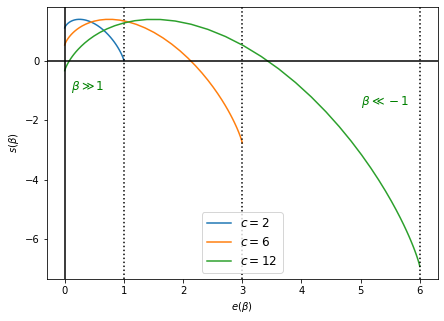

In [166]:
fig, ax = plt.subplots(figsize=(7,5))

q = 4
betas = np.linspace(-10, 10, 100)

for c in [2, 6, 12]:
    
    # Compute energy and entropy for range of betas
    energy = paramagnetic_energy(c, betas, q)
    entropy = paramagnetic_entropy(c, betas, q)
    
    plt.plot(energy, entropy, label=r'$c={}$'.format(c))
    plt.axvline(c/2, ls=':', c='black')


plt.text(+0.1, -1, r'$\beta\gg 1$', color='green', fontsize='large')
plt.text(5, -1.5, r'$\beta\ll -1$', color='green', fontsize='large')

plt.axhline(0, ls='-', c='black')
plt.axvline(0, ls='-', c='black')



plt.xlabel(r'$e(\beta)$')
plt.ylabel(r'$s(\beta)$')

plt.legend(ncol=1, fontsize='large', loc='lower right')
plt.savefig('./figs/chapter5/entropy_paramagnetic.pdf', bbox_inches='tight')

### Figure 2: Bethe Free-energy and mean-field equation for q=2 ferromagnet

In [167]:
def mean_field_update(a, beta, q, d):
    '''
    args:
        a: marginal
        beta: inverse temperature
        q: number of colours
        d: degree
    returns:
        Right-hand side of ferromagnetic mean-field equation
    '''
    enum = (1-(1-np.exp(-beta))*a)**(d-1)
    denom = enum + (q-1) * (1-(1-np.exp(-beta))*(1-a)/(q-1))**(d-1)
    
    return enum/denom

def ferromagnetic_bfe(a, beta, q, d):
    '''
    args:
        a: marginal
        beta: inverse temperature
        q: number of colours
        d: degree
    returns:
        Bethe free entropy for ferromagnetic fixed point
    '''
    term1 = np.log((q-1)*(1-(1-np.exp(-beta))*(1-a)/(q-1))**d + 
                   (1-(1-np.exp(-beta))*a)**d)
    
    term2 = d/2 * np.log(1-(1-np.exp(-beta)) *
                            ((1-a)**2/(q-1) + a**2))

    return term1 - term2

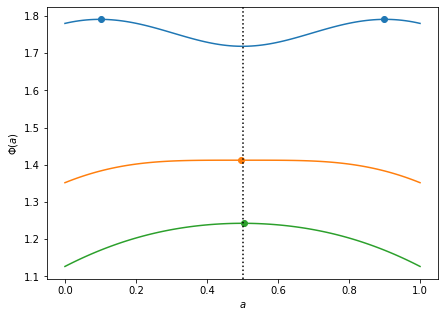

In [168]:
fig, ax = plt.subplots(figsize=(7,5))

q = 2
d = 5

a_range = np.linspace(0, 1, 100)

#for beta in [-0.7, -np.log(1+q/(d-2)), -0.4]:
for beta in [-0.7, -0.5108, -0.4]:
    
    # Compute energy and entropy for range of betas
    pot = ferromagnetic_bfe(a_range, beta, q, d)
    peaks = find_peaks(pot)[0]
            
    #p = plt.plot(a_range, pot-pot[peaks[0]], label=r'$\beta={}$'.format(beta))
    p = plt.plot(a_range, pot, label=r'$\beta={}$'.format(beta))
    color = p[0].get_color()

    for peak in peaks: 
        plt.scatter([a_range[peak]],[pot[peaks[0]]], marker='o', c=color)

    
plt.axvline(1/q, ls=':', c='black', label=r'$1/q$')

plt.xlabel(r'$a$')
#plt.ylabel(r'$\Phi(a)-\Phi(a^*)$')
plt.ylabel(r'$\Phi(a)$')

# plt.legend(ncol=1, fontsize='large')

plt.savefig('./figs/chapter5/free_entropy_ferromagnetic.pdf', bbox_inches='tight')

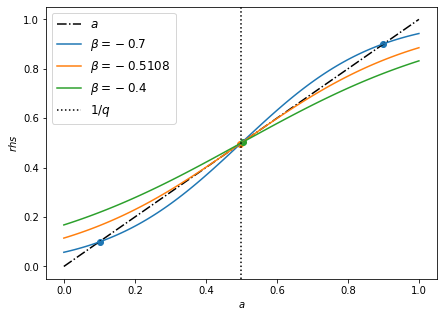

In [169]:
fig, ax = plt.subplots(figsize=(7,5))

q = 2
d = 5

a_range = np.linspace(0, 1, 100)

plt.plot(a_range, a_range, ls='dashdot', c='black',label=r'$a$')

#for beta in [-0.7,-np.log(1+q/(d-2)), -0.4]:
for beta in [-0.7, -0.5108, -0.4]:

    # Compute energy and entropy for range of betas
    rhs = mean_field_update(a_range, beta, q, d)
    
    pot = ferromagnetic_bfe(a_range, beta, q, d)
    peaks = find_peaks(pot)[0]
    
    p = plt.plot(a_range, rhs, label=r'$\beta={}$'.format(beta))
    color = p[0].get_color()

    for peak in peaks: 
        plt.scatter([a_range[peak]], [rhs[peak]], marker='o', c=color)

plt.axvline(1/q, ls=':', c='black', label=r'$1/q$')

plt.xlabel(r'$a$')
plt.ylabel(r'$rhs$')

plt.legend(ncol=1, fontsize='large')

plt.savefig('./figs/chapter5/sp_eq_ferromagnetic.pdf', bbox_inches='tight')

### Figure 3: Equilibrium magnetisation as a function of $\beta$ for $q=2$ (Ising)

In [170]:
def iterate_sp(beta, q, d, tol=1e-7, max_steps=1000, init=0.1):
    '''
    Iterate ferromagnetic mean-field equations
    args:
        - beta: inverse temperature
        - q: number of colours
        - d: average degree
        - tol: tolerance foor convergence
        - max_steps: iteration threshold
        - init: initialisation point
    returns: 
        - fixed point of the mean-field equations
    '''
    a = np.zeros(max_steps)
    a[0] = init
    
    for t in np.arange(max_steps-1):
        a[t+1] = mean_field_update(a[t], beta, q, d)
                
        if np.abs(a[t+1]-a[t]) < tol:
            break
    
    return a[:t+1]

def beta_stab(q, d):
    '''
    Compute critical temperature for transition between 
    paramagnetic and ferromagnetic phase.
    args:
        - q: number of colours
        - d: average degree
    returns:
        - critical temperature
    '''
    return -np.log(1 + q/(d-2))

In [171]:
q=2

data = {'q': [], 'd': [], 'a': [], 'beta': [], 'init': []}

for init in [0.001, 0.999]:
    for d in [2, 3, 4, 5]:
        for beta in np.linspace(-1.5,0.5, 100):
            a = iterate_sp(beta, q, d, init=init)

            data['beta'].append(beta)
            data['q'].append(q)
            data['d'].append(d)
            data['init'].append(init)
            data['a'].append(a[-1])
    
data = pd.DataFrame.from_dict(data)

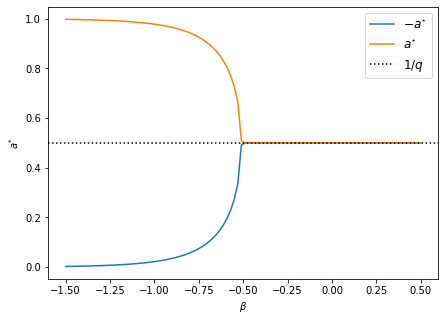

In [172]:
fig, ax = plt.subplots(figsize=(7,5))

data[(data['d']==5) & (data['init']==0.001)].plot(x='beta', y='a', ax=ax, label=r'$-a^{\star}$')
data[(data['d']==5) & (data['init']==0.999)].plot(x='beta', y='a', ax=ax, label=r'$a^{\star}$')

plt.axhline(1/q, ls=':', c='black', label=r'$1/q$')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$a^{*}$')

plt.legend(ncol=1, fontsize='large')

plt.savefig('./figs/chapter5/magnetisation_q=2.pdf', bbox_inches='tight')

### Figure 4: Bethe Free-energy and mean-field equation for $q>2$ ferromagnet

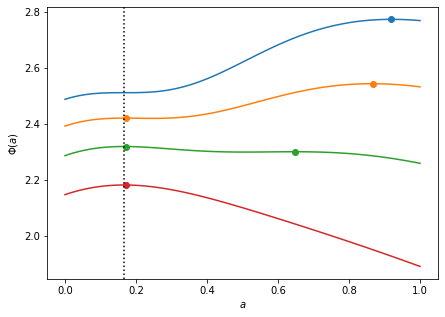

In [173]:
fig, ax = plt.subplots(figsize=(7,5))

q = 6
d = 5

a_range = np.linspace(0, 1, 100)

betac = -0.7526315789473684

for beta in [-1.1, -1.0, -0.88, -0.7]:
    
    # Compute energy and entropy for range of betas
    pot = ferromagnetic_bfe(a_range, beta, q, d)
    peaks = find_peaks(pot)[0]
        
    p = plt.plot(a_range, pot, label=r'$\beta={}$'.format(beta))
    color = p[0].get_color()

    for peak in peaks: 
        plt.scatter([a_range[peak]], [pot[peak]], marker='o', c=color)

    
plt.axvline(1/q, ls=':', c='black', label=r'$1/q$')

plt.xlabel(r'$a$')
plt.ylabel(r'$\Phi(a)$')

# plt.legend(ncol=1, fontsize='large')

plt.savefig('./figs/chapter5/free_entropy_ferromagnetic_q=4.pdf', bbox_inches='tight')

Text(0, 0.5, '$\\Phi(a)$')

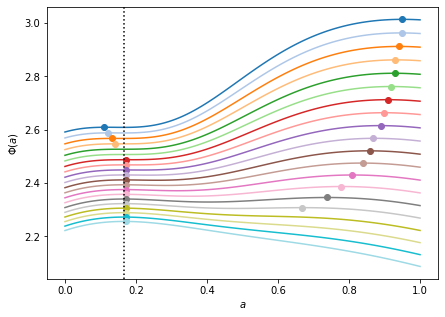

In [174]:
fig, ax = plt.subplots(figsize=(7,5))


# Change default color cycle for all new axes
colors = plt.cm.Spectral(np.linspace(0,1,20))
ax.set_prop_cycle('color', sns.mpl_palette("tab20", 20))

q = 6
d = 5

a_range = np.linspace(0, 1, 100)

for beta in np.linspace(-1.2,-0.8, 20):
    
    # Compute energy and entropy for range of betas
    pot = ferromagnetic_bfe(a_range, beta, q, d)
    peaks = find_peaks(pot)[0]
        
    p = plt.plot(a_range, pot, label=r'$\beta={}$'.format(beta))
    color = p[0].get_color()
    
    for peak in peaks: 
        plt.scatter([a_range[peak]], [pot[peak]], marker='o', color=color)

    
plt.axvline(1/q, ls=':', c='black', label=r'$1/q$')

plt.xlabel(r'$a$')
plt.ylabel(r'$\Phi(a)$')

# plt.legend(ncol=1, fontsize='large')

#plt.savefig('./figs/chapter5/transition_q=4_d=5.pdf', bbox_inches='tight')

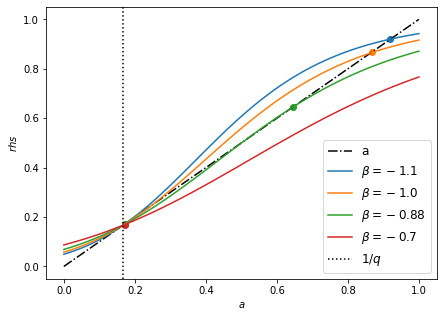

In [175]:
fig, ax = plt.subplots(figsize=(7,5))

q = 6
d = 5

a_range = np.linspace(0, 1, 100)

plt.plot(a_range, a_range, ls='dashdot', c='black', label='a')

for beta in [-1.1, -1.0, -0.88, -0.7]:
    # Compute energy and entropy for range of betas
    rhs = mean_field_update(a_range, beta, q, d)
    
    pot = ferromagnetic_bfe(a_range, beta, q, d)
    peaks = find_peaks(pot)[0]
    
    p = plt.plot(a_range, rhs, label=r'$\beta={}$'.format(beta))
    color = p[0].get_color()
    
    for peak in peaks: 
        plt.scatter([a_range[peak]], [rhs[peak]], marker='o', c=color)

plt.axvline(1/q, ls=':', c='black', label=r'$1/q$')

plt.xlabel(r'$a$')
plt.ylabel(r'$rhs$')

plt.legend(ncol=1, fontsize='large')

plt.savefig('./figs/chapter5/sp_eq_ferromagnetic_q=4.pdf', bbox_inches='tight')

### Figure 5: Equilibrium magnetisation as a function of $\beta$ for $q>2$ (Potts)

In [176]:
q = 10
d = 5

data = {'q': [], 'd': [], 'a': [], 'beta': [], 'init': [], 'free_entropy': []}

for init in [0.0001, 0.9999, 0.5, 1/q+0.001]:
    for beta in np.linspace(-2,-0.5, 5000):
        a = iterate_sp(beta, q, d, init=init)

        data['beta'].append(beta)
        data['q'].append(q)
        data['d'].append(d)
        data['init'].append(init)
        data['a'].append(a[-1])
        data['free_entropy'].append(ferromagnetic_bfe(a[-1], beta, q, d))

    
data = pd.DataFrame.from_dict(data)

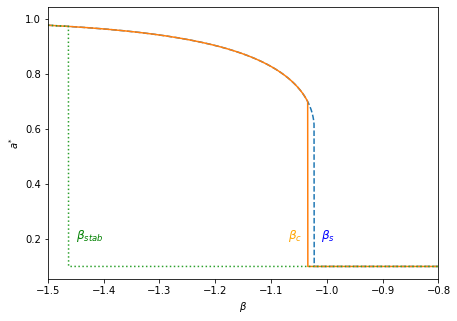

In [177]:
fig, ax = plt.subplots(figsize=(7,5))

betacrit = beta_stab(q, d)

data[(data['d']==5) & (data['init']==0.9999)].plot(x='beta', y='a', ax=ax, style='--', legend=False)
data[(data['d']==5) & (data['init']==0.5)].plot(x='beta', y='a', ax=ax, style='-', legend=False)
data[(data['d']==5) & (data['init']==1/q+0.001)].plot(x='beta', y='a', ax=ax, style=':', legend=False)

plt.text(-1.45, 0.2, r'$\beta_{stab}$', color='green', fontsize='large')
plt.text(-1.07, 0.2, r'$\beta_{c}$', color='orange', fontsize='large')
plt.text(-1.01, 0.2, r'$\beta_{s}$', color='blue', fontsize='large')


plt.xlabel(r'$\beta$')
plt.ylabel(r'$a^{*}$')

plt.xlim([-1.5,-0.8])

plt.savefig('./figs/chapter5/magnetisation_q=10_d=5.pdf', bbox_inches='tight')

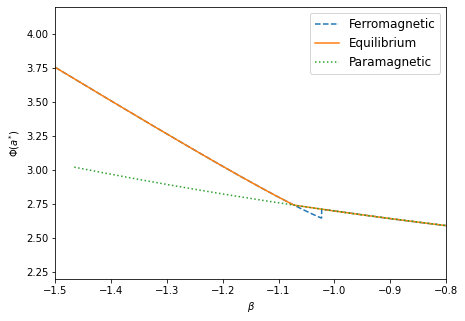

In [178]:
fig, ax = plt.subplots(figsize=(7,5))

free_entropy = np.maximum(data[data['init']==0.9999]['free_entropy'].values, 
                          data[data['init']==0.0001]['free_entropy'].values)
beta_range = np.linspace(-2,-0.5, 5000)

betastab = beta_stab(q, d)
betac = -1.08

data[(data['d']==5) & (data['init']==0.9999)].plot(x='beta', 
                                                   y='free_entropy', 
                                                   ax=ax,  
                                                   style='--', 
                                                   label='Ferromagnetic')

plt.plot(beta_range, free_entropy, label='Equilibrium', ls='-')


data[(data['d']==5) & (data['init']==0.0001) & (data['beta']>betacrit)].plot(x='beta', 
                                                   y='free_entropy', 
                                                   ax=ax, 
                                                   style=':',
                                                   label='Paramagnetic')


# plt.axvline(betastab, ls='dashdot', c='black', label=r'$\beta_{stab}$')

ax.set_ylim([2.2,4.2])
plt.xlim([-1.5,-0.8])

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\Phi(a^{*})$')


plt.legend(ncol=1, fontsize='large')

plt.savefig('./figs/chapter5/free_entropy_betas_q=10_d=5.pdf', bbox_inches='tight')

### Figure 6: Ferromagnetic entropy

In [179]:
def ferromagnetic_energy(a, beta, q, d):
    term1 = d / (2*(1-(a-1)*np.exp(beta)*(q*(a+1)-2)/(1+a*(a*q-2))))
    
    enum1 = (a-1)*(1+(a-1)*(1-np.exp(-beta))/(q-1))**(d-1)
    enum2 = -a*(1+a*(np.exp(-beta)-1))**(d-1)
    enum = d*np.exp(-beta)*(enum1+enum2)
    
    denom = (1+a*(np.exp(-beta)-1))**d + (q-1) * (1+(a-1)*(1-np.exp(-beta))/(q-1))**d
    
    return -(term1+enum/denom)

def ferromagnetic_entropy(a, beta, q, d):
    return ferromagnetic_bfe(a, beta, q, d) + beta * ferromagnetic_energy(a, beta, q, d)

In [180]:
q = 4
d = 6

data = {'q': [], 'd': [], 'a': [], 'beta': [], 'init': [], 
        'free_entropy': [], 'entropy': [], 'energy': []}

for init in [0.0001, 0.9999, 1/q]:
    for beta in np.linspace(-10, 10, 2000):
        a = iterate_sp(beta, q, d, init=init)

        data['beta'].append(beta)
        data['q'].append(q)
        data['d'].append(d)
        data['init'].append(init)
        data['a'].append(a[-1])
        data['free_entropy'].append(ferromagnetic_bfe(a[-1], beta, q, d))
        data['entropy'].append(ferromagnetic_entropy(a[-1], beta, q, d))
        data['energy'].append(ferromagnetic_energy(a[-1], beta, q, d))

    
data = pd.DataFrame.from_dict(data)

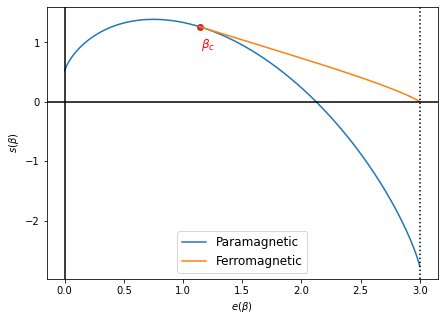

In [182]:
fig, ax = plt.subplots(figsize=(7,5))

betastab = beta_stab(q, d)
betac = -0.61

data[(data['d']==6) & 
     (data['init']==1/q)].plot(x='energy', 
                               y='entropy', 
                               ax=ax, 
                               style='-',
                               label='Paramagnetic')

data[(data['d']==6) & 
     (data['init']==0.9999) & 
     (data['beta'] < -0.6)].plot(x='energy', 
                              y='entropy', 
                              ax=ax,  
                              style='-', 
                              label='Ferromagnetic')


plt.scatter([paramagnetic_energy(d, betac, q)], [paramagnetic_entropy(d, betac, q)], marker='o', c=color)

plt.axhline(0, ls='-', c='black')
plt.axvline(0, ls='-', c='black')
plt.axvline(3, ls=':', c='black')

plt.text(1.15, 0.9, r'$\beta_{c}$', color='red', fontsize='large')

plt.xlabel(r'$e(\beta)$')
plt.ylabel(r'$s(\beta)$')


plt.legend(ncol=1, fontsize='large')

plt.savefig('./figs/chapter5/entropy_para_vs_ferro.pdf', bbox_inches='tight')